In [1]:
# expected_loss = Probability of Default (PD) * Exposure at Default (EAD) * Loss Given Default (LGD)
# in this course we try to calculate the probability of default given some data as input
# Two primary types of data : 
#     1- application data: interest rate, grade, amount of the loan, ...
#     2- Behavioral data: Employment length, Income amount, Historical Default, age, loan intent, home ownership ...

In [40]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [192]:
cr_loan = pd.read_csv("F:\\schulich\\datacamp\\applied finance\\3- Credit Risk Modeling in Python\\credit_risk_dataset.csv")
cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
# Check the structure of the data
print(cr_loan.dtypes)

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


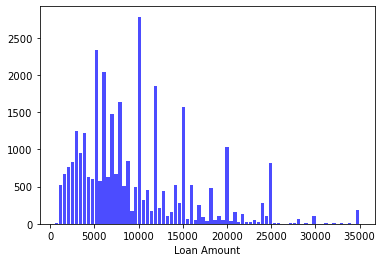

In [5]:
# Look at the distribution of loan amounts with a histogram
n, bins, patches = plt.hist(x=cr_loan['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()

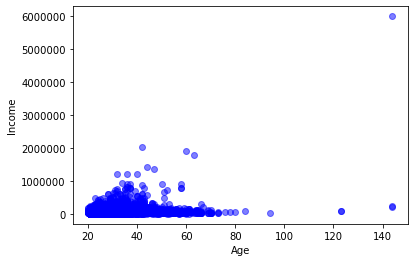

In [12]:
# lets check the inter relationship between some of the variables, for example we want to see if there is a relationship
# between age and income
# Plot a scatter plot of income against age
plt.scatter(cr_loan['person_age'], cr_loan['person_income'],c='blue', alpha=0.5)
plt.xlabel('Age')
plt.ticklabel_format(style='plain') # to avoid showing the income in scientific notation like 1* 1e6 
plt.ylabel('Income')
plt.show()

In [15]:
# we can create cross tables the are pivot tables and summerize and aggregate data
pd.crosstab(cr_loan['loan_intent'], cr_loan['loan_status'], margins = True)
# loan_statue: default = 1, Non_default = 0 

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,5212
EDUCATION,5342,1111,6453
HOMEIMPROVEMENT,2664,941,3605
MEDICAL,4450,1621,6071
PERSONAL,4423,1098,5521
VENTURE,4872,847,5719
All,25473,7108,32581


In [16]:
# For most credit risk models, especially for probability of default, columns like person_emp_length and 
# person_home_ownership are common to begin investigating.

# Create a cross table of home ownership grouped by loan_status and loan_grade.
print(pd.crosstab(cr_loan['person_home_ownership'],[cr_loan['loan_status'],cr_loan['loan_grade']]))

loan_status               0                                 1             \
loan_grade                A     B     C    D    E   F  G    A     B    C   
person_home_ownership                                                      
MORTGAGE               5219  3729  1934  658  178  36  0  239   324  321   
OTHER                    23    29    11    9    2   0  0    3     5    6   
OWN                     860   770   464  264   26   7  0   66    34   31   
RENT                   3602  4222  2710  554  137  28  1  765  1338  981   

loan_status                               
loan_grade                D    E   F   G  
person_home_ownership                     
MORTGAGE                553  161  61  31  
OTHER                    11    6   2   0  
OWN                      18   31   8   5  
RENT                   1559  423  99  27  


In [17]:
# For now, you need to check how loan_status is affected by factors like home ownership status, loan grade,
# and loan percentage of income.

#  Create a cross table of home ownership, loan status, and average percent income
print(pd.crosstab(cr_loan['person_home_ownership'], cr_loan['loan_status'],
              values=cr_loan['loan_percent_income'], aggfunc='mean'))

loan_status                   0         1
person_home_ownership                    
MORTGAGE               0.146504  0.184882
OTHER                  0.143784  0.300000
OWN                    0.180013  0.297358
RENT                   0.144611  0.264859


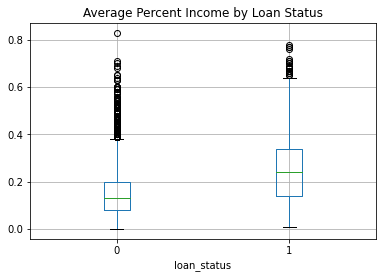

In [19]:
# Create a box plot of percentage income by loan status
cr_loan.boxplot(column = ['loan_percent_income'], by = 'loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

In [20]:
# before modeling the probability of default, we need to prepare data, since in our data set there are some outliers and
# missing data that can lead to inaccuracy of our model, these ourliers could be due to mistakes made during entering data.
# this step is very important because with out removing them we will end up with wrong numbers. 

# ROC charts show that using pre-processed data instead of just using raw data can increase ROC near to 1 which proves the
# better performance of our model. in the future we will learn how to create and interpret ROC charts. 

# the first step in data prepration is to detect and remove outliers, because outliers can lead to wrong coefficients and
# putting higher weights for the factors that are not realy as important.

# in order to detect outliers we can use crosstab or visualization.
pd.crosstab(cr_loan['person_home_ownership'], cr_loan['loan_status'],
values=cr_loan['loan_int_rate'], aggfunc='mean').round(2)


loan_status,0,1
person_home_ownership,,
MORTGAGE,10.06,13.43
OTHER,11.41,13.56
OWN,10.75,12.24
RENT,10.75,12.97


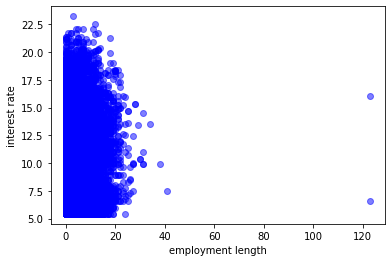

In [26]:
# for visualization we can use scatter plots or histograms
plt.scatter(x = cr_loan['person_emp_length'], y = cr_loan['loan_int_rate'],c='blue', alpha=0.5)
plt.ylabel('interest rate')
plt.xlabel('employment length')
plt.show()

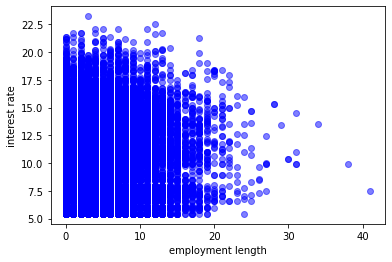

In [30]:
# as you see there are two outlier having more than 120 year of employment lenght which obviously is not correct.
# lets remove them using drop method
indices = cr_loan[cr_loan['person_emp_length'] >= 60].index
cr_loan_new = cr_loan.drop(indices)

plt.scatter(x = cr_loan_new['person_emp_length'], y = cr_loan_new['loan_int_rate'],c='blue', alpha=0.5)
plt.ylabel('interest rate')
plt.xlabel('employment length')
plt.show()

# as you see these data are more realalitic

In [29]:
# Create the cross table for loan status, home ownership, and the max employment length
print(pd.crosstab(cr_loan['loan_status'],cr_loan['person_home_ownership'],
        values=cr_loan['person_emp_length'], aggfunc='max'))
# you see that the number of 123 years of employment length is unusual and considered as an outlier as we saw abo

person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         123.0   24.0  31.0   41.0
1                          34.0   11.0  17.0  123.0


In [35]:
# create a cross table with the new cr_loan
print(pd.crosstab(cr_loan_new['loan_status'],cr_loan_new['person_home_ownership'],
        values=cr_loan_new['person_emp_length'], aggfunc='max'))
# as you see the numbers are more acceptable.

person_home_ownership  MORTGAGE  OTHER   OWN  RENT
loan_status                                       
0                          38.0   24.0  31.0  41.0
1                          34.0   11.0  17.0  27.0


In [34]:
pd.crosstab(cr_loan_new['loan_status'],cr_loan_new['person_home_ownership'],
        values=cr_loan_new['person_emp_length'], aggfunc='max')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,38.0,24.0,31.0,41.0
1,34.0,11.0,17.0,27.0


In [36]:
# we also need to see if there is any negative number as the empoyment lenght
pd.crosstab(cr_loan_new['loan_status'],cr_loan_new['person_home_ownership'],
        values=cr_loan_new['person_emp_length'], aggfunc='min')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0


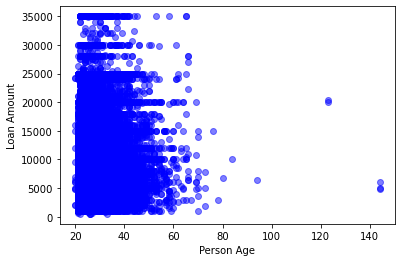

In [38]:
# You discovered outliers in person_emp_length where values greater than 60 were far above the norm. person_age is
# another column in which a person can use a common sense approach to say it is very unlikely that a person applying
# for a loan will be over 100 years old.

# Create the scatter plot for age and amount
plt.scatter(cr_loan['person_age'], cr_loan['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()


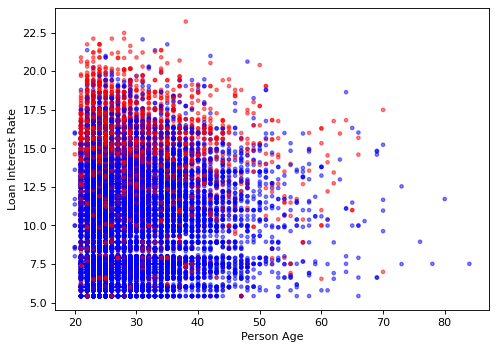

In [51]:
# Use Pandas to drop the record from the data frame and create a new one
indices = cr_loan[cr_loan['person_age'] > 100].index
cr_loan_new = cr_loan.drop(indices)

# Create a scatter plot of age and interest rate
from matplotlib.pyplot import figure
figure(figsize=(7, 5), dpi=80)


colors = ["blue","red"]
plt.scatter(x = cr_loan_new['person_age'], y = cr_loan_new['loan_int_rate'],
            c = cr_loan_new['loan_status'],
            cmap = matplotlib.colors.ListedColormap(colors),
            alpha=0.5 , s=10)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

In [52]:
# missing data
# if there is NaN or None or "" or and other unacceptable values for data we can either remove the whole row or replace
# it with median or mean

# we can find the number of null values in each column
null_columns = cr_loan.columns[cr_loan.isnull().any()]
cr_loan[null_columns].isnull().sum()

person_emp_length     895
loan_int_rate        3116
dtype: int64

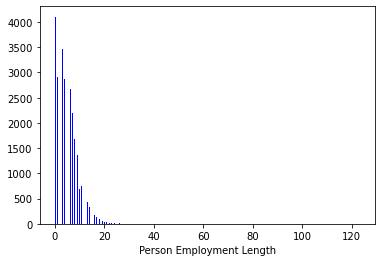

In [54]:
# lets look at the histogram of person_employment_length with null values
n, bins, patches = plt.hist(cr_loan['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

Index(['person_emp_length', 'loan_int_rate'], dtype='object')
     person_age  person_income person_home_ownership  person_emp_length  \
105          22          12600              MORTGAGE                NaN   
222          24         185000              MORTGAGE                NaN   
379          24          16800              MORTGAGE                NaN   
407          25          52000                  RENT                NaN   
408          22          17352              MORTGAGE                NaN   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
105           PERSONAL          A       2000           5.42            1   
222          EDUCATION          B      35000          12.42            0   
379  DEBTCONSOLIDATION          A       3900            NaN            1   
407           PERSONAL          B      24000          10.74            1   
408          EDUCATION          C       2250          15.27            0   

     loan_percent_income cb_pe

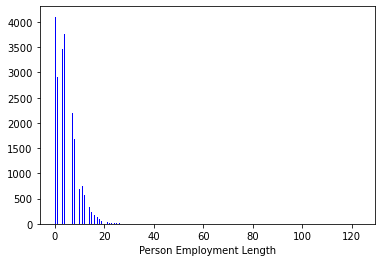

In [55]:
# Print a null value column array
print(cr_loan.columns[cr_loan.isnull().any()])

# Print the top five rows with nulls for employment length
print(cr_loan[cr_loan['person_emp_length'].isnull()].head())

# Impute the null values with the median value for all employment lengths
cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)
# Create a histogram of employment length
n, bins, patches = plt.hist(cr_loan['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

In [60]:
# in the above we replaced employment length with median, here we want to drop the rows with null values for interest rate.
# Print the number of nulls
print(cr_loan['loan_int_rate'].isnull().sum())

# Store the array on indices
indices = cr_loan[cr_loan['loan_int_rate'].isnull()].index

# Save the new data without missing data
cr_loan_clean = cr_loan.drop(indices)

3116


In [64]:
# the credit risk model is a classification machine learning problem that classifies the result into two classes: default:1
# and non-default:0
# we want to predict the probability of default which shows the likelihood that someone defualt on paying off the debt
# there are two common models for classifiactionL: logistic regression and decision tree
# for now we use logistic regression, logistic regression is similar to regression except that its y value is between 0 and 1

# Single-Variable logistic regression
# the below lines is intending to show you how the logistic regression modeling works
from sklearn.linear_model import LogisticRegression

# Create the X and y data sets
X = cr_loan_clean[['loan_int_rate']]
y = cr_loan_clean[['loan_status']]

# Create and fit a logistic regression model
clf_logistic_single = LogisticRegression(solver='lbfgs')
clf_logistic_single.fit(X, np.ravel(y))

# Print the parameters of the model
print(clf_logistic_single.get_params())


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [63]:
# Print the intercept of the model
print(clf_logistic_single.intercept_)

[-4.4586918]


In [65]:
# Multivariate logistic regression
# Generally, you won't use only loan_int_rate to predict the probability of default. You will want to use all the data
# you have to make predictions.
# Create X data for the model
X_multi = cr_loan_clean[['loan_int_rate','person_emp_length']]

# Create a set of y data for training
y = cr_loan_clean[['loan_status']]

# Create and train a new logistic regression
clf_logistic_multi = LogisticRegression(solver='lbfgs').fit(X_multi, np.ravel(y))

# Print the intercept of the model
print(clf_logistic_multi.intercept_)

[-4.2253171]


In [237]:
# Creating training and test sets
# Create the X and y data sets
from sklearn.model_selection import train_test_split


X = cr_loan_clean[['loan_int_rate','person_emp_length','person_income']]
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123) # 40% test, 60% train

# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Print the models coefficients
print(clf_logistic.coef_)

[[ 8.34020099e-02 -6.02470833e-02 -3.28983416e-05]]


In [74]:
# we want to see if using different training and test data generate different coefficients?
# Print the first five rows of each training set

X = cr_loan_clean[['loan_int_rate','person_emp_length','person_income']]
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=.4, random_state=110) 
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=.4, random_state=130) 

print(X1_train.head())
print(X2_train.head())

       loan_int_rate  person_emp_length  person_income
18313          10.65                6.0         117000
12655           7.88                0.0          84000
19412          10.08                0.0          30000
10704          13.49                7.0          70000
24948          10.00                2.0          78400
       loan_int_rate  person_emp_length  person_income
25746           6.54               10.0          36000
5915           12.69                3.0          47300
25735          15.23                3.0          90000
32189           8.90                2.0          31000
30538          16.29               13.0          58000


In [75]:
# Create and train a model on the first training data
clf_logistic1 = LogisticRegression(solver='lbfgs').fit(X1_train, np.ravel(y1_train))

# Create and train a model on the second training data
clf_logistic2 = LogisticRegression(solver='lbfgs').fit(X2_train, np.ravel(y2_train))

# Print the coefficients of each model
print(clf_logistic1.coef_)
print(clf_logistic2.coef_)
# as you see some coefficients are different and some are close

[[ 8.16436156e-02 -1.37820491e-02 -3.64959751e-05]]
[[ 8.32648717e-02 -6.61833274e-02 -3.17958276e-05]]


In [79]:
# what if some of our X values are not numerical and are string
# we need to use dummy variables, this method is called One-hot encoding credit data
# first we need to find the categorical (in the form of string) in our data set and save numerical and categorical in two
# differnt variables

# Create two data sets for numeric and non-numeric data
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])

print(cred_num.head(), '\n', '\n', '---------------------------------------------------------')
print(cred_str.head())

   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          22          59000              123.0      35000          16.02   
1          21           9600                5.0       1000          11.14   
2          25           9600                1.0       5500          12.87   
3          23          65500                4.0      35000          15.23   
4          24          54400                8.0      35000          14.27   

   loan_status  loan_percent_income  cb_person_cred_hist_length  
0            1                 0.59                           3  
1            0                 0.10                           2  
2            1                 0.57                           3  
3            1                 0.53                           2  
4            1                 0.55                           4   
 
 ---------------------------------------------------------
  person_home_ownership loan_intent loan_grade cb_person_default_on_file
0     

In [80]:
# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)
cred_str_onehot.head()
# it has a lot of columns

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1


In [81]:
# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print the columns in the new data set
print(cr_loan_prep.columns)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')


In [233]:
# Predicting probability of default

# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)
preds

array([[0.79640467, 0.20359533],
       [0.86259881, 0.13740119],
       [0.88037836, 0.11962164],
       ...,
       [0.65634664, 0.34365336],
       [0.95987007, 0.04012993],
       [0.95050992, 0.04949008]])

In [232]:
# Create two data frames, preds_df and true_df, to store the first five predictions and true loan_status values.
preds_df = pd.DataFrame(preds)
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

       loan_status         0         1
0                0  0.796405  0.203595
1                0  0.862599  0.137401
2                0  0.880378  0.119622
3                0  0.692560  0.307440
4                0  0.494215  0.505785
...            ...       ...       ...
11781            0  0.882389  0.117611
11782            1  0.521010  0.478990
11783            1  0.656347  0.343653
11784            0  0.959870  0.040130
11785            1  0.950510  0.049490

[11786 rows x 3 columns]


In [223]:
preds

array([[0.79640467, 0.20359533],
       [0.86259881, 0.13740119],
       [0.88037836, 0.11962164],
       ...,
       [0.65634664, 0.34365336],
       [0.95987007, 0.04012993],
       [0.95050992, 0.04949008]])

In [224]:
# model evaluation
# before using the model we need to evaluate its performance
# Creating a data frame of the probabilities makes them easier to work with, because you can use all the power of pandas.
# Apply the threshold to the data and check the value counts for both classes of loan_status to see how many predictions
# of each are being created. This will help with insight into the scores from the classification report.

# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])
preds_df

,prob_default
0,0.203595
1,0.137401
2,0.119622
3,0.307440
4,0.505785
...,...
11781,0.117611
11782,0.478990
11783,0.343653
11784,0.040130


In [94]:
# Reassign loan_status values based on a threshold of 0.50 for probability of default in preds_df.
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0) # you use lambda when you want to
# use a function only once and you dont want to define a function
preds_df

,prob_default,loan_status
0,0.203595,0
1,0.137401,0
2,0.119622,0
3,0.307440,0
4,0.505785,1
...,...,...
11781,0.117611,0
11782,0.478990,0
11783,0.343653,0
11784,0.040130,0


In [95]:
# Print the value counts of the number of rows for each loan_status.
print(preds_df['loan_status'].value_counts())


0    10861
1      925
Name: loan_status, dtype: int64


In [96]:
# Print the classification report
from sklearn.metrics import classification_report
# this will show us several different evaluation metrics all at once. two of the very useful: precition and recall
# 
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.81      0.96      0.88      9194
     Default       0.62      0.22      0.33      2592

    accuracy                           0.80     11786
   macro avg       0.72      0.59      0.61     11786
weighted avg       0.77      0.80      0.76     11786



In [160]:
# we can get query specific numbers from the above report
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test,preds_df['loan_status'])[2][1] # 3rd column and second  [2][1]

0.46198466956701884

In [99]:
# Print all the non-average values from the report
print(precision_recall_fscore_support(y_test,preds_df['loan_status']))


(array([0.81447381, 0.62378378]), array([0.96214923, 0.22260802]), array([0.88217402, 0.32812056]), array([9194, 2592], dtype=int64))


In [107]:
# Print the first two numbers from the report
print(precision_recall_fscore_support(y_test,preds_df['loan_status'])[0])

[0.81447381 0.62378378]


In [108]:
# another way to measure the performance is to calculate the accuracy of the model
# accuracy = number of correct predictions / number of predictions
clf_logistic.score(X_test,y_test)

0.7995078907178008

In [109]:
# another way to measure the performance of your model is ROC chart, which visualizes the performance

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
prob_default

array([0.20359533, 0.13740119, 0.11962164, ..., 0.34365336, 0.04012993,
       0.04949008])

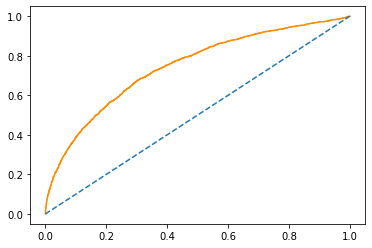

In [115]:
from sklearn.metrics import roc_curve

fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()
# the closer the orange line to 1 the better the model, so the area below ornage line is AUC

In [117]:
# we can calculate the AUC of the model
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, prob_default)
auc

0.7437090992313827

In [119]:
# Thresholds and confusion matrices
# logically thinking, it makes sense that if probability of default is greater than 0.5 we assume default and below no-defa
# but sometimes it does not give the best results and its better to see by implementing what value for treshhold we
# generate better performance

# Set different values for the threshold on probability of default, and use a confusion matrix to see how the
# changing values affect the model's performance.


# Set the threshold for defaults to 0.5
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0) 
# Print the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,preds_df['loan_status'])

array([[8846,  348],
       [2015,  577]], dtype=int64)

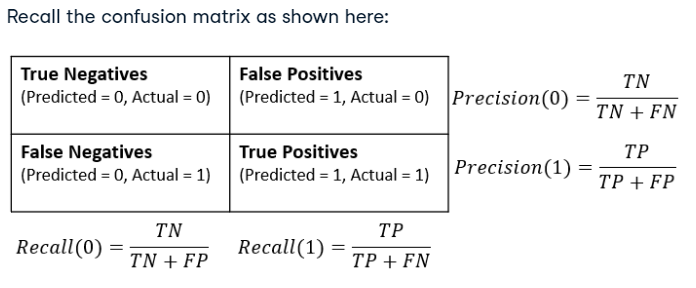

In [120]:
# change the threshold for defaults to 0.4 an see what happens to the confusion matrix
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0) 

confusion_matrix(y_test,preds_df['loan_status'])

# we can calculate recall and precision to see what threshold yields the best results.

array([[8074, 1120],
       [1477, 1115]], dtype=int64)

In [121]:
# Reassign the values of loan status based on the new threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0) 
preds_df

,prob_default,loan_status
0,0.203595,0
1,0.137401,0
2,0.119622,0
3,0.307440,0
4,0.505785,1
...,...,...
11781,0.117611,0
11782,0.478990,1
11783,0.343653,0
11784,0.040130,0


In [122]:
preds_df['loan_status'].value_counts()

0    9551
1    2235
Name: loan_status, dtype: int64

In [123]:
# Store the number of loan defaults from the prediction data
num_defaults = preds_df['loan_status'].value_counts()[1]
num_defaults


2235

In [126]:
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.85      0.88      0.86      9194
     Default       0.50      0.43      0.46      2592

    accuracy                           0.78     11786
   macro avg       0.67      0.65      0.66     11786
weighted avg       0.77      0.78      0.77     11786



In [125]:
precision_recall_fscore_support(y_test,preds_df['loan_status'])

(array([0.84535651, 0.49888143]),
 array([0.87818142, 0.43016975]),
 array([0.86145639, 0.46198467]),
 array([9194, 2592], dtype=int64))

In [158]:
# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]
default_recall

0.43016975308641975

In [124]:
# calculate average loan amount
avg_loan_amnt = cr_loan_clean['loan_amnt'].mean()
avg_loan_amnt

9584.744612251825

In [128]:
# Calculate the estimated impact of the new default recall rate
print(num_defaults * avg_loan_amnt * (1 - default_recall))

12206848.964421853


In [147]:
# Threshold selection
# You know there is a trade off between metrics like default recall, non-default recall, and model accuracy.
# One easy way to approximate a good starting threshold value is to look at a plot of all three using matplotlib. 
# With this graph, you can see how each of these metrics look as you change the threshold values and find the point 
# at which the performance of all three is good enough to use for the credit data.

thresh = np.linspace(0.2,0.65,19)
thresh

array([0.2  , 0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  ,
       0.425, 0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625,
       0.65 ])

In [181]:
from sklearn.metrics import accuracy_score


def_recalls = []
nondef_recalls = []
accs = []
for i in range(0,19):
    preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > thresh[i] else 0)
    def_recalls.append(precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1])
    nondef_recalls.append(precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][0])
    accs.append(accuracy_score(y_test, preds_df['loan_status']))

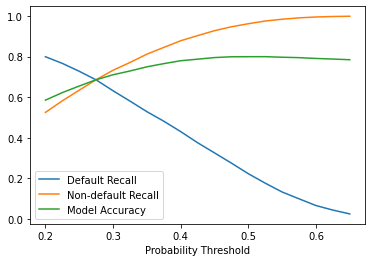

In [184]:
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

# so we can decide to select the best threshold based on the whicm metric is more important. 
# obviously if for example threshhold is zero. so it predicts all to br default so its default recall would be 100% but
# the non-default recall would be 0% which is not acceptable. so you should decide to use which threshold. 

In [261]:
# XGBoost: is another type of machine learning model that works based on Decision Tree and is very similar to logistic
# regression, even the sytax is also very similar. we want to build this model as well and then compare its performance
# with our regression model that we previously built. 

# we need to train a gradiant boosted tree.
# Train a model
import xgboost as xgb

clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
preds_gbt= clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_gbt = pd.DataFrame(gbt_preds)
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_gbt], axis = 1))



C:\Users\sasan\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
       loan_status         0         1
0                0  0.898857  0.101143
1                0  0.630626  0.369374
2                0  0.991898  0.008102
3                0  0.888827  0.111173
4                0  0.531822  0.468178
...            ...       ...       ...
11781            0  0.937802  0.062198
11782            1  0.205094  0.794906
11783            1  0.800821  0.199179
11784            0  0.989772  0.010228
11785            1  0.921802  0.078198

[11786 rows x 3 columns]


In [262]:
# trying to get the loan amount for the indices in X_test

Loan_amount_test = cr_loan_clean['loan_amnt'].loc[X_test.index]
Loan_amount_test.reset_index(drop = True, inplace=True)
Loan_amount_test = pd.DataFrame(Loan_amount_test)
Loan_amount_test

,loan_amnt
0,9000
1,11000
2,3700
3,10800
4,7500
...,...
11781,12000
11782,8000
11783,11900
11784,10000


In [276]:
# in order to compare these two models we need to make a portfolio including probabilities and loan amount and loan given 
# default to calculate Expected Loss
portfolio = []
LGD = pd.DataFrame([0.2] * 11786)  # assume Loss Given Default is 20%
portfolio.append(preds_gbt[1])
portfolio.append(preds_df[1])
portfolio.append(LGD[0])
portfolio = pd.DataFrame(portfolio).T
portfolio = portfolio.join(Loan_amount_test)

new_column_list = ['gbt_prob_default', 'lr_prob_default', 'lgd','loan_amnt']
portfolio.set_axis(new_column_list, axis=1, inplace=True)

portfolio

,gbt_prob_default,lr_prob_default,lgd,loan_amnt
0,0.101143,0.203595,0.2,9000
1,0.369374,0.137401,0.2,11000
2,0.008102,0.119622,0.2,3700
3,0.111173,0.307440,0.2,10800
4,0.468178,0.505785,0.2,7500
...,...,...,...,...
11781,0.062198,0.117611,0.2,12000
11782,0.794906,0.478990,0.2,8000
11783,0.199179,0.343653,0.2,11900
11784,0.010228,0.040130,0.2,10000


In [277]:
# Create expected loss columns for each model using the formula
portfolio['gbt_expected_loss'] = portfolio['gbt_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']
portfolio['lr_expected_loss'] = portfolio['lr_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))

# Print the sum of the expected loss for gbt
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

LR expected loss:  4568499.889791362
GBT expected loss:  4525206.786873277


In [283]:
# predict is different from predict_proba

# Predict the labels for loan status
gbt_preds = clf_gbt.predict(X_test)

# Check the values created by the predict method
gbt_preds_dataframe = pd.DataFrame(gbt_preds)
gbt_preds_dataframe.tail()

,0
11781,0
11782,1
11783,0
11784,0
11785,0


In [286]:
# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds , target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.86      0.96      0.91      9194
     Default       0.74      0.45      0.56      2592

    accuracy                           0.84     11786
   macro avg       0.80      0.70      0.73     11786
weighted avg       0.83      0.84      0.83     11786



In [297]:
# Columns importance and Columns prediction in XGBoost
# using all columns does not necessarily yield better models in both regression and decision trees, if the columns are not 
# relevant they might make difficulties for the model to learn. 
# in regression the coefficients show the importance of each column whereas in XGBoost to find the weights that show the

X = cr_loan_prep[['person_income','loan_int_rate',
                  'loan_percent_income','loan_amnt',
                  'person_home_ownership_MORTGAGE','loan_grade_F']]

y = cr_loan_prep[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)


In [298]:
# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# importance of each column is claculated by using : .get_booster().get_score which returns a dictionary of each column and
# their weights. 
# weights show the number of times that each column appeared in the trees. 
# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

C:\Users\sasan\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'loan_percent_income': 585, 'loan_int_rate': 994, 'person_income': 1299, 'loan_amnt': 533, 'person_home_ownership_MORTGAGE': 115, 'loan_grade_F': 17}


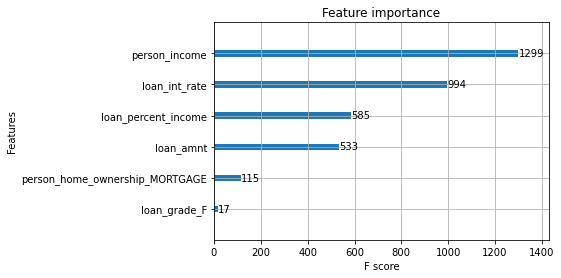

In [301]:
# Visualizing column importance

# Plot the column importance for this model
xgb.plot_importance(clf_gbt, importance_type = 'weight')
plt.show()

C:\Users\sasan\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:33:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


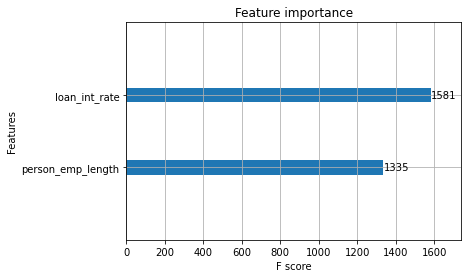

In [303]:
X2 = cr_loan_prep[['loan_int_rate','person_emp_length']]


y = cr_loan_prep[['loan_status']]

# Use test_train_split to create the training and test sets
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)

# Train a model on the X data with 2 columns
clf_gbt2 = xgb.XGBClassifier().fit(X2_train, np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt2, importance_type = 'weight')
plt.show()


[19:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


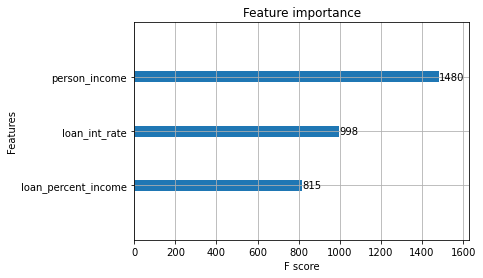

In [304]:
X3 = cr_loan_prep[['person_income','loan_int_rate','loan_percent_income']]

y = cr_loan_prep[['loan_status']]

# Use test_train_split to create the training and test sets
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=.4, random_state=123)

# Train a model on the X data with 3 columns
clf_gbt3 = xgb.XGBClassifier().fit(X3_train, np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt3, importance_type = 'weight')
plt.show()


In [347]:
# Column selection and model performance

# Creating the training set from different combinations of columns affects the model and the importance values of the
# columns. Does a different selection of columns also affect the F-1 scores, the combination of the precision and recall,
# of the model? (F-1 Score is very useful because recall and precision usually move in the opposite way but F-1 Score take
# both into account) You can answer this question by training two different models on two different sets of columns, and 
# checking the performance.



# Predict the loan_status using each model
gbt_preds = clf_gbt.predict(X_test)
gbt2_preds = clf_gbt2.predict(X2_test)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds , target_names=target_names))

# Print the classification report of the second model
print(classification_report(y_test, gbt2_preds , target_names=target_names))

# as you see using columns in X has higher f1-score for both default and non-default

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9194
     Default       0.96      0.74      0.84      2592

    accuracy                           0.94     11786
   macro avg       0.94      0.87      0.90     11786
weighted avg       0.94      0.94      0.93     11786

              precision    recall  f1-score   support

 Non-Default       0.83      0.97      0.89      9194
     Default       0.71      0.28      0.40      2592

    accuracy                           0.82     11786
   macro avg       0.77      0.63      0.65     11786
weighted avg       0.80      0.82      0.78     11786



In [310]:
# Cross validating credit models
# Credit loans and their data change over time, and it won't always look like what's been loaded into the current test sets.
# So, you can use cross-validation to try several smaller training and test sets which are derived from the original
# X_train and y_train.
# Use the XGBoost function cv() to perform cross-validation. You will need to set up all the parameters for cv() to use
# on the test data.

params = {'eval_metric': 'auc', 'objective': 'binary:logistic', 'seed': 123}

# Set the values for number of folds and stopping iterations

n_folds = 5
early_stopping = 10

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)  # DMatrix is an internal structure optimized for XGBoost, it contains the
                                                # train data but in a specific format specially for XGBoost. 

# Create the data frame of cross validations: Cross Validation works is some way similar to scenarion analysis. 
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
early_stopping_rounds=early_stopping)

# Print the cross validations data frame
print(cv_df)
# as you see auc is improving step by step

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.881806       0.001795       0.872216      0.008822
1        0.887735       0.001098       0.877671      0.008170
2        0.891360       0.002140       0.880851      0.007495
3        0.894470       0.001379       0.882568      0.007724
4        0.896968       0.001140       0.883956      0.007535


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.881215       0.001403       0.872696      0.012551
1        0.887388       0.001580       0.877595      0.012738
2        0.891297       0.000954       0.881628      0.011674
3        0.893464       0.000768       0.882840      0.011189
4        0.896269       0.000837       0.883879      0.010970
0.9023240656666661


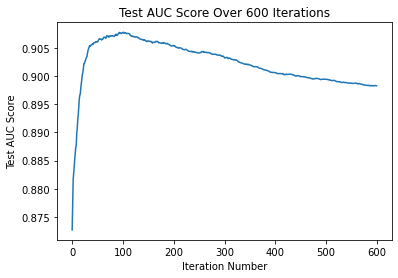

In [312]:
# Limits to cross-validation testing
# You can specify very large numbers for both nfold and num_boost_round if you want to perform an extreme amount 
# of cross-validation. 
cv_results_big = xgb.cv(params, DTrain, num_boost_round = 600, nfold=10,
            shuffle = True)

# Print the first five rows of the CV results data frame
print(cv_results_big.head())

# Calculate the mean of the test AUC scores
print(np.mean(cv_results_big['test-auc-mean']))

# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

In [315]:
# Cross-validation scoring
# Now, you should use cross-validation scoring with cross_val_score() to check the overall performance.

# This is exercise presents an excellent opportunity to test out the use of the hyperparameters learning_rate and 
# max_depth. Remember, hyperparameters are like settings which can help create optimum performance.

# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7, use_label_encoder=False)

# Calculate the cross validation scores for 4 folds
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Print the cross validation scores
print(cv_scores)


[11:12:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [316]:

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

Average accuracy: 0.89 (+/- 0.01)


In [317]:
# we just used cross validation to check the robustness of our model. lets talk about how the data impacts the robustness
# of the model.in our credit data, the values for loan status are our classes. by looking at the value count we see that 
# the number of defaults and non-defaults are not equal:
y_train['loan_status'].value_counts()
# there are far more non-defaults than defaults, which makes the class imbalance, which is a problem.

0    13807
1     3872
Name: loan_status, dtype: int64

In [322]:
# our tree model use a loss function called log-loss. our model tries to predict both class accurately which leads to 
# better overal score.  
# IMPORTANT: the problem is for loans, a default predicted to be a non-default is much more costly, because we lose
# the whole loan, whre as is we predict a non default as a default we just lose the opportunity profit which is lower
# than the whole principal + interest
# how to deal with class imbalance:
#     1- Gather more data: increase the number of default data, but still prcentage will be the same
#     2- Penalize the classification model differently.
#     3- Sample data differently. 
# how penalize model works: this would have models weights inaccurately predicted defaults more as they are more costly
# the cons of this method is that it require frequent model parameter tuning and maintenance for the life of the model. 

# we will use the sample method: which is to sample the training data differenctly. 
# the type of sampling we are going to perform is called undersampling. what we will do is to take a random sample of 
# non-defaults and combine it with our defaults. imagine we have 100 loans where 80% are non-defaults. we will randomly
# sample only 20 of our non-defaults and combine that with our 20 set of defaults. with this we have a balanced training 
# set of 20 defualts and 20 non-defaults. 


X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

print(count_nondefault, count_default)

13807 3872


In [319]:
X_y_train

,person_income,loan_int_rate,loan_percent_income,loan_amnt,person_home_ownership_MORTGAGE,loan_grade_F,loan_status
0,81900,7.66,0.10,8000,1,0,0
1,47700,11.99,0.25,12000,0,0,0
2,48000,13.48,0.10,5000,1,0,0
3,19200,13.49,0.10,2000,0,0,0
4,75000,6.03,0.14,10200,1,0,0
...,...,...,...,...,...,...,...
17674,43439,12.73,0.35,15000,0,0,1
17675,60000,11.71,0.05,3000,0,0,0
17676,42600,15.62,0.23,10000,0,0,1
17677,52000,6.76,0.07,3500,1,0,0


In [323]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

nondefaults

,person_income,loan_int_rate,loan_percent_income,loan_amnt,person_home_ownership_MORTGAGE,loan_grade_F,loan_status
0,81900,7.66,0.10,8000,1,0,0
1,47700,11.99,0.25,12000,0,0,0
2,48000,13.48,0.10,5000,1,0,0
3,19200,13.49,0.10,2000,0,0,0
4,75000,6.03,0.14,10200,1,0,0
...,...,...,...,...,...,...,...
17670,115600,7.29,0.09,9925,1,0,0
17671,58200,12.53,0.17,10000,1,0,0
17675,60000,11.71,0.05,3000,0,0,0
17677,52000,6.76,0.07,3500,1,0,0


In [324]:
defaults

,person_income,loan_int_rate,loan_percent_income,loan_amnt,person_home_ownership_MORTGAGE,loan_grade_F,loan_status
5,108000,15.31,0.19,20000,0,0,1
7,4200,16.95,0.65,2750,0,0,1
12,89000,14.74,0.09,8000,0,0,1
13,73000,16.70,0.31,22400,0,0,1
17,34500,14.42,0.13,4500,1,0,1
...,...,...,...,...,...,...,...
17666,12816,12.87,0.23,3000,0,0,1
17672,24000,13.16,0.51,12250,0,0,1
17673,60000,15.70,0.03,2000,1,0,1
17674,43439,12.73,0.35,15000,0,0,1


In [325]:
# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)
nondefaults_under

,person_income,loan_int_rate,loan_percent_income,loan_amnt,person_home_ownership_MORTGAGE,loan_grade_F,loan_status
9452,53000,13.80,0.34,18000,1,0,0
1324,60000,7.90,0.20,12000,1,0,0
15713,100000,10.59,0.18,17600,1,0,0
9330,84996,11.99,0.04,3600,0,0,0
5675,144000,8.90,0.03,5000,1,0,0
...,...,...,...,...,...,...,...
441,97000,9.91,0.12,12000,1,0,0
6059,105897,11.36,0.24,25000,1,0,0
10641,30000,13.49,0.20,6000,0,0,0
2466,53100,7.90,0.24,13000,0,0,0


In [326]:

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                            defaults.reset_index(drop = True)], axis=0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

# now we have a balance classs of defaults and non defaults

0    3872
1    3872
Name: loan_status, dtype: int64


In [327]:
X_y_train_under

,person_income,loan_int_rate,loan_percent_income,loan_amnt,person_home_ownership_MORTGAGE,loan_grade_F,loan_status
0,53000,13.80,0.34,18000,1,0,0
1,60000,7.90,0.20,12000,1,0,0
2,100000,10.59,0.18,17600,1,0,0
3,84996,11.99,0.04,3600,0,0,0
4,144000,8.90,0.03,5000,1,0,0
...,...,...,...,...,...,...,...
3867,12816,12.87,0.23,3000,0,0,1
3868,24000,13.16,0.51,12250,0,0,1
3869,60000,15.70,0.03,2000,1,0,1
3870,43439,12.73,0.35,15000,0,0,1


In [329]:
X_y_train_under.columns

Index(['person_income', 'loan_int_rate', 'loan_percent_income', 'loan_amnt',
       'person_home_ownership_MORTGAGE', 'loan_grade_F', 'loan_status'],
      dtype='object')

In [330]:
# Undersampled tree performance
# The performance of the model's predictions not only impact the probability of default on the test set, but also on 
# the scoring of new loan applications as they come in. You also now know that it is even more important that the
# recall of defaults be high, because a default predicted as non-default is more costly.


In [331]:
# Comparing model reports
# You've used logistic regression models and gradient boosted trees. It's time to compare these two to see which model
# will be used to make the final predictions.

# One of the easiest first steps for comparing different models' ability to predict the probability of default is to look
# at their metrics from the classification_report(). With this, you can see many different scoring metrics side-by-side
# for each model. Because the data and models are normally unbalanced with few defaults, focus on the metrics for defaults
# for now.

cr_loan_prep.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')

In [333]:
X = cr_loan_prep.drop(['loan_status'], axis=1)
X

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,0.59,3,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0.10,2,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,0.57,3,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,0.53,2,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,0.55,4,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0.11,30,1,0,0,...,0,0,0,1,0,0,0,0,1,0
32577,54,120000,4.0,17625,7.49,0.15,19,1,0,0,...,0,1,0,0,0,0,0,0,1,0
32578,65,76000,3.0,35000,10.99,0.46,28,0,0,0,...,0,0,1,0,0,0,0,0,1,0
32579,56,150000,5.0,15000,11.48,0.10,26,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [334]:
y = cr_loan_prep[['loan_status']]
y


,loan_status
0,1
1,0
2,1
3,1
4,1
...,...
32576,0
32577,0
32578,1
32579,0


In [340]:
# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123) # 40% test, 60% train

# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))
preds_lr = clf_logistic.predict_proba(X_test)
preds_lr = clf_logistic.predict_proba(X_test)

preds_lr_df = pd.DataFrame(preds_lr)

preds_lr_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])
preds_df_lr['loan_status'] = preds_lr_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0) # you use lambda when you want to

preds_df_lr



,prob_default,loan_status
0,0.129805,0
1,0.243161,0
2,0.100325,0
3,0.252148,0
4,0.377654,0
...,...,...
11781,0.096698,0
11782,0.520755,1
11783,0.464550,1
11784,0.049818,0


In [343]:
# Create and fit the XGBoost model
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))
preds_gbt = clf_gbt.predict(X_test)
preds_gbt= clf_gbt.predict_proba(X_test)

preds_df_gbt = pd.DataFrame(preds_gbt)

preds_df_gbt = pd.DataFrame(preds_gbt[:,1], columns = ['prob_default'])

preds_df_gbt['loan_status'] = preds_df_gbt['prob_default'].apply(lambda x: 1 if x > 0.4 else 0) # you use lambda when you want to

preds_df_gbt

C:\Users\sasan\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,prob_default,loan_status
0,0.069717,0
1,0.000514,0
2,0.001946,0
3,0.045644,0
4,0.432617,1
...,...,...
11781,0.041030,0
11782,0.998818,1
11783,0.981503,1
11784,0.002784,0


In [350]:
# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_lr['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print(classification_report(y_test, preds_df_gbt['loan_status'], target_names=target_names))

# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test, preds_df_lr['loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test, preds_df_gbt['loan_status'], average = 'macro')[2])

              precision    recall  f1-score   support

 Non-Default       0.86      0.92      0.89      9194
     Default       0.62      0.45      0.52      2592

    accuracy                           0.82     11786
   macro avg       0.74      0.69      0.71     11786
weighted avg       0.80      0.82      0.81     11786

              precision    recall  f1-score   support

 Non-Default       0.94      0.98      0.96      9194
     Default       0.92      0.76      0.83      2592

    accuracy                           0.93     11786
   macro avg       0.93      0.87      0.90     11786
weighted avg       0.93      0.93      0.93     11786

0.7051224860306248
0.8963682684237266


In [349]:
# from the above data, macro average f1 score is very useful for making comparison between our two models. 
# macro average F1 Score is the unweighted average of F1 scores for defaults and non defaults. This signle number gives us
# a good understanding of defaults and non-defaults. 


# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test, preds_df_lr['loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test, preds_df_gbt['loan_status'], average = 'macro')[2])

0.7051224860306248
0.8963682684237266


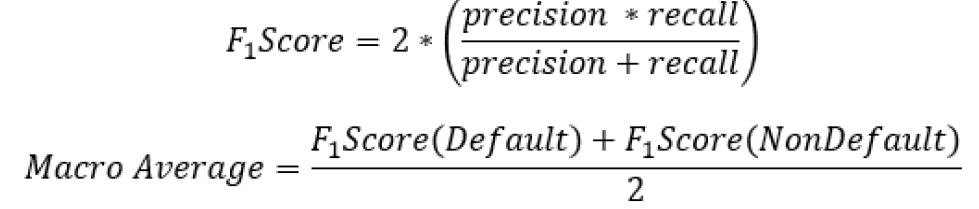

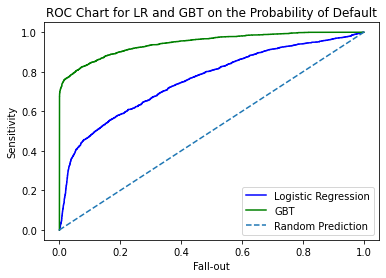

In [351]:
# Comparing with ROCs
# You should use ROC charts and AUC scores to compare the two models. Sometimes, visuals can really help you and potential
# business users understand the differences between the various models under consideration.
# With the graph in mind, you will be more equipped to make a decision. The lift is how far the curve is from the random
# prediction. The AUC is the area between the curve and the random prediction. The model with more lift, and a higher AUC,
# is the one that's better at making predictions accurately.

# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, preds_df_lr['prob_default'])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, preds_df_gbt['prob_default'])


# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [352]:
# AUC is also considering both defaults and non-defaults. So it gives us a good understanding of the performance of the 
# models for both defaults and non-defaults. 

# the above graph shows that AUC for GBT is greater than Logistic regression. you can see the exact number as well:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, preds_df_lr['prob_default']))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, preds_df_gbt['prob_default']))

Logistic Regression AUC Score: 0.76
Gradient Boosted Tree AUC Score: 0.95


In [361]:
# Model calibration
# another method is to check how well the probabilities are. 
# We want our probabilities of default to accurately represent the model's confidence level.
#       The probability of default has a degree of uncertainty in it's predictions
# A sample of loans and their predicted probabilities of default should be close to the percentage of defaults in
# that sample
# to calculate the above we use calibration curve function. 

# You now know that the gradient boosted tree clf_gbt has the best overall performance. 
# You need to check the calibration of the two models to see how stable the default prediction performance is across
# probabilities. You can use a chart of each model's calibration to check this by calling the calibration_curve() function

from sklearn.calibration import calibration_curve
calibration_curve_lr = calibration_curve(y_test, preds_df_lr['prob_default'], n_bins = 20)
calibration_curve_gbt = calibration_curve(y_test, preds_df_gbt['prob_default'], n_bins = 20)

print(calibration_curve_lr)
print('----------------------------------------------------------------------------------------------------------')
print(calibration_curve_gbt)

(array([0.08009858, 0.06725795, 0.12307692, 0.13935681, 0.16590563,
       0.1967632 , 0.19961796, 0.24855491, 0.44325768, 0.75768535,
       0.75174825, 0.74657534, 0.69014085, 0.67391304, 0.42857143,
       0.75      ]), array([0.02083356, 0.0754332 , 0.12520031, 0.17516272, 0.2241329 ,
       0.27476044, 0.3233148 , 0.37500475, 0.4237752 , 0.4741421 ,
       0.52294546, 0.57364994, 0.62167009, 0.67341514, 0.72625279,
       0.77310435]))
----------------------------------------------------------------------------------------------------------
(array([0.02388485, 0.0877428 , 0.14304813, 0.16385542, 0.25193798,
       0.21604938, 0.27007299, 0.19607843, 0.36144578, 0.45454545,
       0.65909091, 0.525     , 0.52380952, 0.64516129, 0.65384615,
       0.78571429, 0.91891892, 0.95454545, 1.        , 0.99873016]), array([0.01513493, 0.07130834, 0.12235251, 0.17329102, 0.22405565,
       0.27273448, 0.3243882 , 0.37318023, 0.4233526 , 0.47436996,
       0.52419931, 0.57589157, 0.62567146, 

In [363]:
frac_of_pos_lr = calibration_curve_lr[0]
frac_of_pos_lr

array([0.08009858, 0.06725795, 0.12307692, 0.13935681, 0.16590563,
       0.1967632 , 0.19961796, 0.24855491, 0.44325768, 0.75768535,
       0.75174825, 0.74657534, 0.69014085, 0.67391304, 0.42857143,
       0.75      ])

In [364]:
mean_pred_val_lr = calibration_curve_lr[1]
frac_of_pos_gbt = calibration_curve_gbt[0]
mean_pred_val_gbt = calibration_curve_gbt[1]

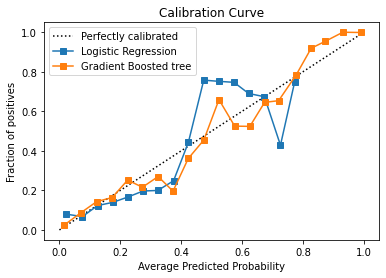

In [365]:
# Create the calibration curve plot with the guideline
# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

In [412]:
# Thresholds and acceptance rate
# the first threshold we used was 0.4 which was arbitarily. but after building the model we need to recalculate the
# threshold to be used as a benchmark for new loan, the predicted probability of default will be compared to the new 
# recalculated threshold to decide if the bank wants to give loan to that new profile or not.
# in order to recalcuate the threshold we need to use the acceptance rate (in this exercise 85%) as a quantile. 
# Acceptance rate: what percentage of new loans are accepted to keep the number of defaults in a portfolio low
# Accepted loans which are defaults have an impact similar to false negatives

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123) # 40% test, 60% train
X_test

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
30015,47,70000,2.0,9000,12.87,0.13,14,0,0,0,...,0,0,0,1,0,0,0,0,1,0
22648,29,56700,14.0,11000,10.62,0.19,6,0,0,1,...,0,0,1,0,0,0,0,0,1,0
9634,22,63000,6.0,3700,5.42,0.06,4,1,0,0,...,0,1,0,0,0,0,0,0,1,0
3455,25,55000,2.0,10800,13.57,0.20,2,0,0,0,...,1,0,0,1,0,0,0,0,1,0
16426,26,32000,1.0,7500,13.79,0.23,3,0,0,0,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,24,86000,1.0,12000,10.65,0.14,3,0,0,0,...,0,0,1,0,0,0,0,0,1,0
27532,27,19200,3.0,8000,8.90,0.42,8,0,0,1,...,0,1,0,0,0,0,0,0,1,0
12162,23,35000,2.0,11900,7.66,0.34,3,0,0,0,...,0,1,0,0,0,0,0,0,1,0
28766,27,98004,8.0,10000,6.54,0.10,7,0,0,0,...,1,1,0,0,0,0,0,0,1,0


In [413]:
y_test

,loan_status
30015,0
22648,0
9634,0
3455,0
16426,0
...,...
13023,0
27532,1
12162,1
28766,0


In [414]:
X_test.join(y_test)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_status
30015,47,70000,2.0,9000,12.87,0.13,14,0,0,0,...,0,0,1,0,0,0,0,1,0,0
22648,29,56700,14.0,11000,10.62,0.19,6,0,0,1,...,0,1,0,0,0,0,0,1,0,0
9634,22,63000,6.0,3700,5.42,0.06,4,1,0,0,...,1,0,0,0,0,0,0,1,0,0
3455,25,55000,2.0,10800,13.57,0.20,2,0,0,0,...,0,0,1,0,0,0,0,1,0,0
16426,26,32000,1.0,7500,13.79,0.23,3,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,24,86000,1.0,12000,10.65,0.14,3,0,0,0,...,0,1,0,0,0,0,0,1,0,0
27532,27,19200,3.0,8000,8.90,0.42,8,0,0,1,...,1,0,0,0,0,0,0,1,0,1
12162,23,35000,2.0,11900,7.66,0.34,3,0,0,0,...,1,0,0,0,0,0,0,1,0,1
28766,27,98004,8.0,10000,6.54,0.10,7,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [415]:
test_pred_df = preds_df_gbt
test_pred_df

,prob_default,loan_status
0,0.069717,0
1,0.000514,0
2,0.001946,0
3,0.045644,0
4,0.432617,1
...,...,...
11781,0.041030,0
11782,0.998818,1
11783,0.981503,1
11784,0.002784,0


In [416]:
y_test_reseted_index = y_test.reset_index()
y_test_reseted_index = y_test_reseted_index.drop(['index'], axis = 1)
y_test_reseted_index.rename(columns={'loan_status': 'true_loan_status'}, inplace=True)
y_test_reseted_index

,true_loan_status
0,0
1,0
2,0
3,0
4,0
...,...
11781,0
11782,1
11783,1
11784,0


In [417]:
test_pred_df = test_pred_df.join(y_test_reseted_index)
test_pred_df

,prob_default,loan_status,true_loan_status
0,0.069717,0,0
1,0.000514,0,0
2,0.001946,0,0
3,0.045644,0,0
4,0.432617,1,0
...,...,...,...
11781,0.041030,0,0
11782,0.998818,1,1
11783,0.981503,1,1
11784,0.002784,0,0


In [418]:
# Check the statistics of the probabilities of default
print(test_pred_df['prob_default'].describe())

count    11786.000000
mean         0.212839
std          0.344421
min          0.000002
25%          0.008941
50%          0.041768
75%          0.181321
max          1.000000
Name: prob_default, dtype: float64


In [419]:
# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(test_pred_df['prob_default'], 0.85)
threshold_85

0.8468102812767029

In [420]:
# Apply acceptance rate threshold and Reassign loan_status values using the new threshold
test_pred_df['pred_loan_status_new_threshold'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)
test_pred_df

,prob_default,loan_status,true_loan_status,pred_loan_status_new_threshold
0,0.069717,0,0,0
1,0.000514,0,0,0
2,0.001946,0,0,0
3,0.045644,0,0,0
4,0.432617,1,0,0
...,...,...,...,...
11781,0.041030,0,0,0
11782,0.998818,1,1,1
11783,0.981503,1,1,1
11784,0.002784,0,0,0


In [424]:
# Print the counts of loan status after and before the threshold
print(test_pred_df['loan_status'].value_counts())
print(test_pred_df['pred_loan_status_new_threshold'].value_counts())

0    9637
1    2149
Name: loan_status, dtype: int64
0    10018
1     1768
Name: pred_loan_status_new_threshold, dtype: int64


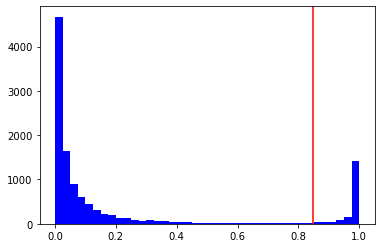

In [426]:
# Visualizing quantiles of acceptance
# You know how quantile() works to compute a threshold, and you've seen an example of what it does to split the loans
# into accepted and rejected. What does this threshold look like for the test set, and how can you visualize it?

# To check this, you can create a histogram of the probabilities and add a reference line for the threshold. With this,
# you can visually show where the threshold exists in the distribution.

# Plot the predicted probabilities of default
plt.hist(test_pred_df['prob_default'] , color = 'blue', bins = 40)

# Calculate the threshold with quantile

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold_85, color = 'red')
plt.show()

In [428]:
# Bad Rates
# Even with a calculated threshold, some of the accepted loans will be defaults
# These are loans with prob_default values around where our model is not well calibrated
# Bad rates = number of accepted defaults / total number of accepted loans

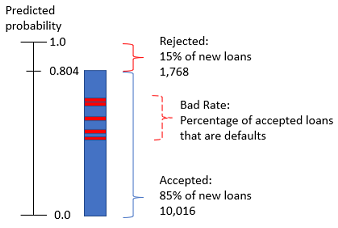

In [435]:
# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status_new_threshold'] == 0]
accepted_loans


,prob_default,loan_status,true_loan_status,pred_loan_status_new_threshold
0,0.069717,0,0,0
1,0.000514,0,0,0
2,0.001946,0,0,0
3,0.045644,0,0,0
4,0.432617,1,0,0
...,...,...,...,...
11778,0.003547,0,0,0
11779,0.094716,0,0,0
11780,0.496315,1,1,0
11781,0.041030,0,0,0


In [436]:
# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

# This bad rate doesn't look half bad! The bad rate with the threshold set by the 85% quantile() is about 8%. 
# This means that of all the loans we've decided to accept from the test set, only 8% were actual defaults! 
# If we accepted all loans, the percentage of defaults would be around 22%.

0.08285086843681373


In [ ]:
# Acceptance rate impact
# Now, look at the loan_amnt of each loan to understand the impact on the portfolio for the acceptance rates.
# You can use cross tables with calculated values, like the average loan amount, of the new set of loans X_test.
# For this, you will multiply the number of each with an average loan_amnt value.

In [441]:
# first we need to loan amount to our test_pred_df data
X_test_loan_amount_reseted_index = X_test['loan_amnt'].reset_index()
test_pred_df = test_pred_df.join(X_test_loan_amount_reseted_index)
test_pred_df

,prob_default,loan_status,true_loan_status,pred_loan_status_new_threshold,index,loan_amnt
0,0.069717,0,0,0,30015,9000
1,0.000514,0,0,0,22648,11000
2,0.001946,0,0,0,9634,3700
3,0.045644,0,0,0,3455,10800
4,0.432617,1,0,0,16426,7500
...,...,...,...,...,...,...
11781,0.041030,0,0,0,13023,12000
11782,0.998818,1,1,1,27532,8000
11783,0.981503,1,1,1,12162,11900
11784,0.002784,0,0,0,28766,10000


In [442]:
# Print the statistics of the loan amount column
print(test_pred_df['loan_amnt'].describe())


count    11786.000000
mean      9524.917275
std       6219.271738
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


In [443]:
# Store the average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])
avg_loan

9524.917274732734

In [444]:
# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status_new_threshold']).apply(lambda x: x * avg_loan, axis = 0))

# Nice! With this, we can see that our bad rate of about 8% represents an estimated loan value of about 7.9 million dollars.
# This may seem like a lot at first, but compare it to the total value of non-default loans! With this, we are ready to 
# start talking about our acceptance strategy going forward. 

pred_loan_status_new_threshold              0              1
true_loan_status                                            
0                              $87,514,939.92     $57,149.50
1                               $7,905,681.34 $16,782,904.24


In [445]:
# Credit Strategy and minimum expected loss
# we have looked at the acceptance rates to calculate thresholds and we calculated bad rates to see how many defaults
# are accepted.
# now lets talk about how we test many different acceptance rates and how we can estimate total expected loss. 
# previously we just set the acceptance rate of 85%. But what if we do not know what values to set as acceptance rate.


In [446]:
# Selecting acceptance rates
# First acceptance rate was set to 85%, but other rates might be selected as well 
# Two options to test di(erent rates:
#       1- Calculate the threshold, bad rate, and losses manually
#       2- Automatically create a table of these values and select an acceptance rate
# The table of all the possible values is called a strategy table

In [448]:
# Making the strategy table
# Before you implement a strategy, you should first create a strategy table containing all the possible acceptance rates
# you wish to look at along with their associated bad rates and threshold values. This way, you can begin to see each 
# part of your strategy and how it affects your portfolio

accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
# Create lists to store thresholds and bad rates
thresholds = []
bad_rates = []

# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(test_pred_df['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(preds_df_gbt['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status_new_threshold'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status_new_threshold'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))

In [452]:
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

# Excellent! That for loop was a lot of code, but look at this sweet strategy table we have now. 
# This uses our specific predictions on the credit data, and can be used to see the acceptance rates, bad rates,
# and financial impact all at once. One of these values has the highest estimated value.

    Acceptance Rate  Threshold  Bad Rate
0             $1.00      $1.00     $0.22
1             $0.95      $1.00     $0.18
2             $0.90      $0.99     $0.13
3             $0.85      $0.85     $0.08
4             $0.80      $0.31     $0.06
5             $0.75      $0.18     $0.05
6             $0.70      $0.12     $0.04
7             $0.65      $0.09     $0.03
8             $0.60      $0.07     $0.03
9             $0.55      $0.05     $0.03
10            $0.50      $0.04     $0.02
11            $0.45      $0.03     $0.02
12            $0.40      $0.03     $0.02
13            $0.35      $0.02     $0.01
14            $0.30      $0.01     $0.01
15            $0.25      $0.01     $0.01
16            $0.20      $0.01     $0.01
17            $0.15      $0.00     $0.00
18            $0.10      $0.00     $0.00
19            $0.05      $0.00     $0.00


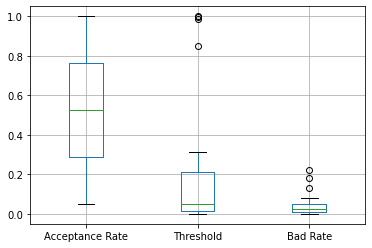

In [457]:
# Visualizing the strategy
# Now you have the extended strategy table strat_df. The table is not so big that it's difficult to analyze, but visuals
# can help you see the overview all at once.

# You should check at the distribution of each column with a box plot. If the distribution of Acceptance Rate looks 
# the same as the Bad Rate column, that could be a problem. That means that the model's calibration is likely much 
# worse than you thought.

# You can also visualize the strategy curve with a line plot. The Acceptance Rate would be the independent variable
# with the Bad Rate as the dependent variable.

# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

# The boxplot shows us the distribution for each column. Look at the strategy curve. The bad rates are very low up
# until the acceptance rate 0.6 where they suddenly increase. This suggests that many of the accepted defaults may
# have a prob_default value between 0.6 and 0.8.

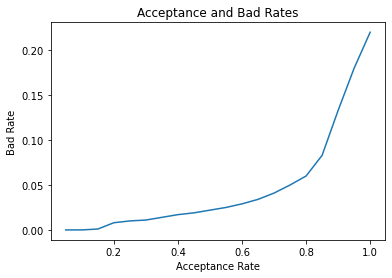

In [459]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.show()

In [463]:
# Estimated value profiling
# The strategy table, strat_df, can be used to maximize the estimated portfolio value and minimize expected loss.
# Extending this table and creating some plots can be very helpful to this end.

# for this we need to add a few more columns, for the sake of time short I just upload one instead of creating it:
strat_df = pd.read_excel("F:\\schulich\\datacamp\\applied finance\\3- Credit Risk Modeling in Python\\new strat.xlsx")
strat_df

,Unnamed: 0,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Avg Loan Amnt,Estimated Value
0,0,$1.00,$1.00,$0.22,11379,"$9,556.28","$61,112,391.49"
1,1,$0.95,$0.99,$0.18,10591,"$9,556.28","$64,977,180.47"
2,2,$0.90,$0.98,$0.13,10025,"$9,556.28","$70,510,056.35"
3,3,$0.85,$0.80,$0.08,9390,"$9,556.28","$74,837,713.31"
4,4,$0.80,$0.25,$0.06,8857,"$9,556.28","$74,313,895.38"
5,5,$0.75,$0.18,$0.05,8229,"$9,556.28","$70,460,210.80"
6,6,$0.70,$0.14,$0.04,7685,"$9,556.28","$67,124,170.79"
7,7,$0.65,$0.11,$0.04,7104,"$9,556.28","$62,999,890.58"
8,8,$0.60,$0.09,$0.03,6456,"$9,556.28","$57,993,623.06"
9,9,$0.55,$0.08,$0.03,5870,"$9,556.28","$53,066,213.97"


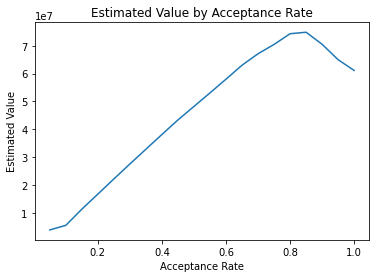

In [465]:
# Create a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'],strat_df['Estimated Value'])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.show()

In [466]:
# Print the row with the max estimated value
print(strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])])

# With our credit data and our estimated averag loan value, we clearly see that the acceptance rate 0.85 has the
# highest potential estimated value. Normally, the allowable bad rate is set, but we can use analyses like this to 
# explore other options.

   Unnamed: 0  Acceptance Rate  Threshold  Bad Rate  Num Accepted Loans  \
3           3            $0.85      $0.80     $0.08                9390   

   Avg Loan Amnt  Estimated Value  
3      $9,556.28   $74,837,713.31  


In [468]:
# Total expected loss
# It's time to estimate the total expected loss given all your decisions. The data frame test_pred_df has the probability
# of default for each loan and that loan's value. Use these two values to calculate the expected loss for each loan.
# Then, you can sum those values and get the total expected loss.

# For this exercise, you will assume that the exposure is the full value of the loan, and the loss given default is 100%.
# This means that a default on each the loan is a loss of the entire amount.

# Print the first five rows of the data frame
print(test_pred_df.head())

# Calculate the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loan_amnt'] * 100/100

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

   prob_default  loan_status  true_loan_status  \
0         $0.07            0                 0   
1         $0.00            0                 0   
2         $0.00            0                 0   
3         $0.05            0                 0   
4         $0.43            1                 0   

   pred_loan_status_new_threshold  index  loan_amnt  
0                               1  30015       9000  
1                               1  22648      11000  
2                               1   9634       3700  
3                               1   3455      10800  
4                               1  16426       7500  
Total expected loss:  $26,498,008.00


In [469]:
# Very nice! This is the total expected loss for the entire portfolio using the gradient boosted tree.
# $27 million may seem like a lot, but the total expected loss would have been over $28 million with the logistic 
# regression. Some losses are unavoidable, but your work here might have saved the company a million dollars